In [1]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
import os
import librosa
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import librosa.display

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [3]:
INPUT_LIB = '~/heartbeat-sounds/'
SAMPLE_RATE = 44100
CLASSES = ['artifact', 'normal', 'extrahls', 'murmur']
CODE_BOOK = {x:i for i,x in enumerate(CLASSES)}   
NB_CLASSES = len(CLASSES)

In [4]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

def load_wav_file(name, path):
    _, b = wavfile.read(path + name)
    assert _ == SAMPLE_RATE
    return b

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

In [5]:
df = pd.read_csv(INPUT_LIB + 'set_a.csv')
df['fname'] = df['fname'].apply(clean_filename, string='Aunlabelledtest')
df['label'].fillna('unclassified')
df['time_series'] = df['fname'].apply(load_wav_file, path=INPUT_LIB + 'set_a/')    
df['len_series'] = df['time_series'].apply(len)
MAX_LEN = max(df['len_series'])
df['time_series'] = df['time_series'].apply(repeat_to_length, length=MAX_LEN)

# print(df['time_series'].values)

In [6]:
x_data = np.stack(df['time_series'].values, axis=0)

In [7]:
from sklearn import preprocessing
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column

labels = df['label'].tolist()
le.fit(labels)
labels = le.transform(labels)
labels = labels.tolist()
print(labels)

# 0 = 'artifact'
# 1 = 'extrahls'
# 2 = 'murmur'
# 3 = 'normal'

print(len(labels))

#for i in range(len(labels)):
#    if labels[i] != 3:
#        new_labels.append(labels[i])

#print(new_labels)
        

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
124


In [8]:
labels = np.array(labels, dtype='int')
y_data = np_utils.to_categorical(labels)

# print(y_data)

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x_data, y_data, df['fname'].values, test_size=0.25)

In [10]:
print(x_train.shape[1:])
print(y_train.shape)

(396900,)
(93, 4)


In [11]:
from scipy.signal import decimate
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)

In [12]:
#Scale each observation to unit variance, it should already have mean close to zero.
x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)

In [13]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

In [14]:
# Set up model here
# use Sequential() to set up model. We use 6 convolution layers to 
# build the model. Between each convolution layer, we do maxpooling and
# batch normalization to downsample an input and to reduce internal 
# covariate shift in neural networks.
# We also introduce dropout to overcome overfitting in the fully connect
# layers.

model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(4, activation='softmax'))

In [15]:
def batch_generator(x_train, y_train, batch_size):
    """
    Rotates the time series randomly in time
    """
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [16]:
weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', 
                               save_best_only=True, save_weights_only=True)

In [17]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

In [18]:
hist = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=30, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=2)

Epoch 1/30
 - 14s - loss: 2.5549 - acc: 0.3339 - val_loss: 1.8096 - val_acc: 0.4516
Epoch 2/30
 - 14s - loss: 1.6250 - acc: 0.5219 - val_loss: 1.4117 - val_acc: 0.4839
Epoch 3/30
 - 13s - loss: 1.3181 - acc: 0.5796 - val_loss: 1.1634 - val_acc: 0.5484
Epoch 4/30
 - 13s - loss: 1.1092 - acc: 0.6295 - val_loss: 1.0271 - val_acc: 0.5806
Epoch 5/30
 - 14s - loss: 0.9890 - acc: 0.6569 - val_loss: 0.9381 - val_acc: 0.6129
Epoch 6/30
 - 13s - loss: 0.9304 - acc: 0.6713 - val_loss: 0.8900 - val_acc: 0.5806
Epoch 7/30
 - 14s - loss: 0.8897 - acc: 0.6723 - val_loss: 0.8590 - val_acc: 0.6129
Epoch 8/30
 - 17s - loss: 0.8607 - acc: 0.6786 - val_loss: 0.8606 - val_acc: 0.6452
Epoch 9/30
 - 17s - loss: 0.8154 - acc: 0.6960 - val_loss: 0.8456 - val_acc: 0.6452
Epoch 10/30
 - 19s - loss: 0.8179 - acc: 0.6880 - val_loss: 0.8338 - val_acc: 0.6452
Epoch 11/30
 - 21s - loss: 0.7816 - acc: 0.7049 - val_loss: 0.8201 - val_acc: 0.6452
Epoch 12/30
 - 20s - loss: 0.7825 - acc: 0.6989 - val_loss: 0.8113 - val_a

In [19]:
model.load_weights('set_a_weights.h5')

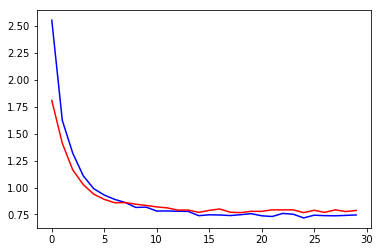

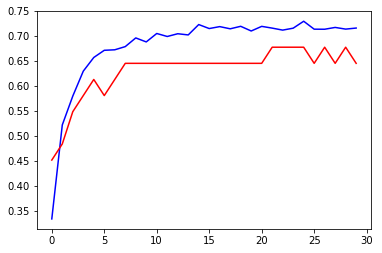

In [20]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

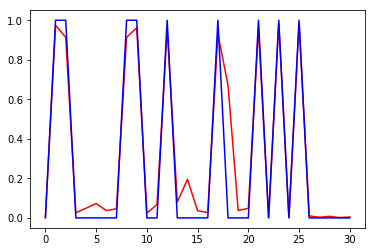

artifact


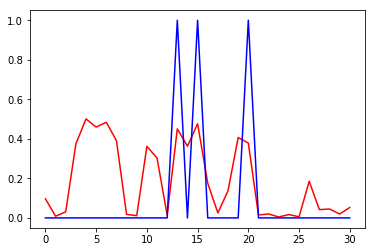

normal


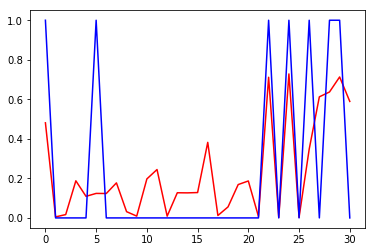

extrahls


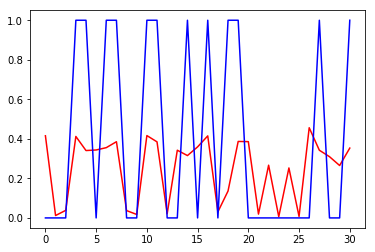

murmur


In [21]:
y_hat = model.predict(x_test)
np.set_printoptions(precision=2, suppress=True)
for i in range(4):
    plt.plot(y_hat[:,i], c='r')
    plt.plot(y_test[:,i], c='b')
    plt.show()
    print(CLASSES[i])

File: normal__201103170121.wav, Pred: normal, True: murmur


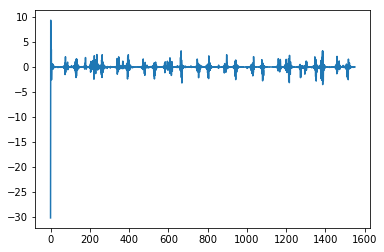

File: murmur__201102051443.wav, Pred: normal, True: extrahls


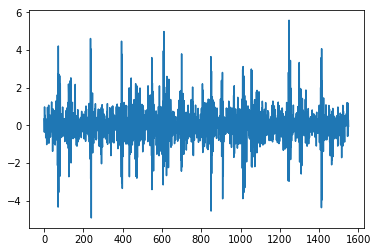

File: normal__201101070538.wav, Pred: normal, True: murmur


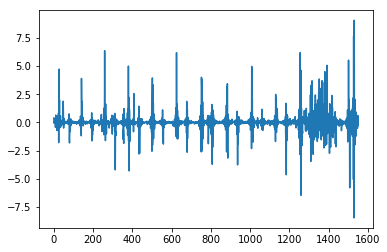

File: normal__201103140822.wav, Pred: normal, True: murmur


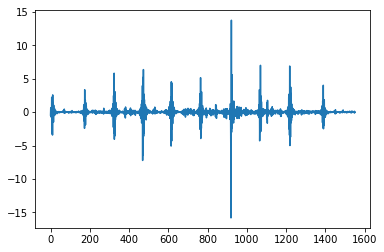

File: normal__201102081152.wav, Pred: normal, True: murmur


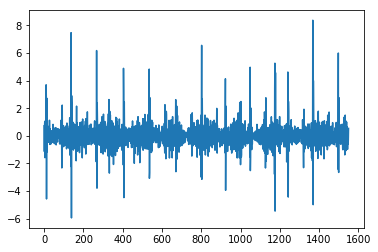

File: normal__201103140135.wav, Pred: artifact, True: murmur


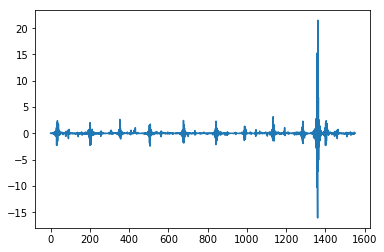

File: normal__201105011626.wav, Pred: normal, True: murmur


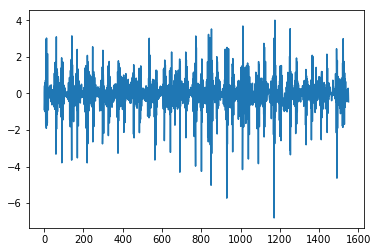

File: extrahls__201103182227.wav, Pred: murmur, True: normal


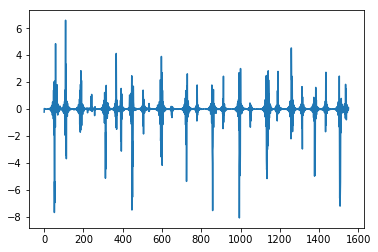

File: murmur__201104241315.wav, Pred: murmur, True: extrahls


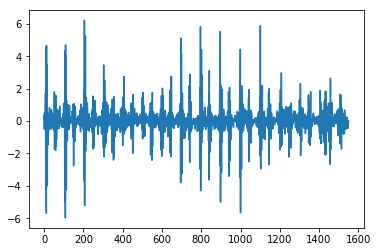

File: normal__201103101140.wav, Pred: extrahls, True: murmur


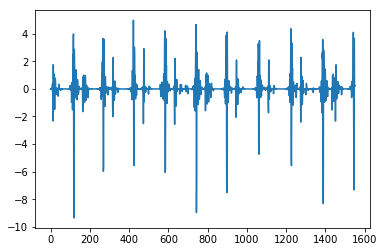

File: normal__201106210943.wav, Pred: extrahls, True: murmur


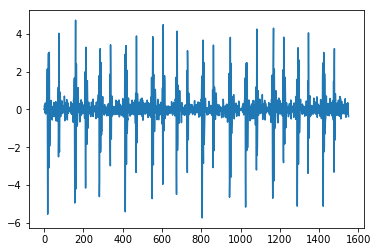

Success match: 0.6451612903225806


In [22]:
# Evaluation

y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)
c = 0
for i in range(len(y_true)):
    if y_pred[i] != y_true[i]:
        print("File: {}, Pred: {}, True: {}".format(
            test_filenames[i],
            CLASSES[y_pred[i]], CLASSES[y_true[i]]))
        plt.plot(x_test[i])
        plt.show()
    else:
        c += 1

print ('Success match:', c/len(y_true))